# New York Bike Share Big Query Data and 2017 Survey

Below are the packages that need to be installed to run this file completely. If there is a comment in the cell, it won't run.

* google-cloud-bigquery: Pip install big query for pulling publically available data via python
* pyarrow: Install a needed dependency for the .to_dataframe() function 
* geopy: Using for the NYBikeShare data. Needing to get the zipcodes from this database to match zipcodes with NYSurvey data for comparison.
* haversine: using to calculate the distance between two points on earth

In [ ]:
pip install google-cloud-bigquery

In [ ]:
pip install pyarrow

In [ ]:
pip install geopy

In [7]:
pip install haversine

Note: you may need to restart the kernel to use updated packages.


In [24]:
# only import bigquery from google cloud
from google.cloud import bigquery
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from geopy.geocoders import Nominatim
from haversine import haversine

plt.style.use('seaborn')

In [2]:
# Changing the settings to override this file path in the environment
import os

# Needing to have the key file downloaded to access via the api. The query can be used
# instead and utilized for this brief analysis.
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/tiareina/Downloads/compact-scene-317315-b4b3cd5c140c.json"

client = bigquery.Client() # Construct a BigQuery client object.

In [3]:
def bigQuery(q: str):
    query_job = client.query(q)  # Make an API request.
    return query_job.to_dataframe().copy() # collect results as a dataframe

### User Type Bike Trips

In [6]:
riders = bigQuery(
    """
    SELECT usertype, count(*) as RideCount
    FROM `bigquery-public-data.new_york_citibike.citibike_trips`
    WHERE starttime > date('2017-01-01') and 
    starttime < date('2018-01-01')
    GROUP BY usertype
    """
)

riders.usertype = riders.usertype.dropna()
riders.RideCount = riders.RideCount.astype(int)
riders = riders.sort_values(by='RideCount',ascending=False)[riders['usertype'] != ""]

riders.head()

,usertype,RideCount
0,Subscriber,12441957
1,Customer,1676712


<AxesSubplot:xlabel='usertype'>

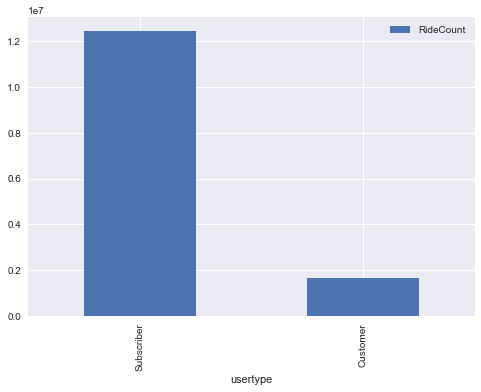

In [7]:
riders.plot(x='usertype', y='RideCount', kind='bar')

In [8]:
#Calculates the average ride time in minutes instead of seconds
userAvgs = bigQuery(
    """
        SELECT usertype, AVG(tripduration)/60 as Average_Ride_Time
        FROM `bigquery-public-data.new_york_citibike.citibike_trips`
        GROUP BY usertype
    """
)

userAvgs = userAvgs[userAvgs['usertype']!='']
userAvgs.head()

,usertype,Average_Ride_Time,Avg_RT_Min
0,Subscriber,806.381888,13.439698
1,Customer,2145.512075,35.758535


In [4]:
# collect results as a dataframe
mostFreqRides = bigQuery(
    """
    SELECT usertype,
    start_station_latitude,
    start_station_longitude,
    end_station_latitude,
    end_station_longitude,
    count(*) AS Count_of_Trips
    FROM `bigquery-public-data.new_york_citibike.citibike_trips`
    WHERE stoptime > DATE('2017-01-01')
    GROUP BY usertype, start_station_latitude, start_station_longitude, end_station_latitude, end_station_longitude
    ORDER BY Count_of_Trips desc;
    """
)

mostFreqRides.head()

,usertype,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,Count_of_Trips
0,Customer,40.765909,-73.976342,40.783070,-73.959390,6783
1,Customer,40.765909,-73.976342,40.765909,-73.976342,6662
2,Customer,40.764397,-73.973715,40.764397,-73.973715,5805
3,Subscriber,40.741740,-73.994156,40.745497,-74.001971,5666
4,Subscriber,40.751873,-73.977706,40.748549,-73.988084,5410


In [25]:
# Find the distance between the start station and the end station
from numpy import cos, sin, arcsin, sqrt
from math import radians

def hs(row):
    loc1 = (row['start_station_latitude'],row['start_station_longitude'])
    loc2 = (row['start_station_latitude'], row['end_station_latitude'])
    return haversine(loc1,loc2,unit='mi')

mostFreqRides['distance'] = mostFreqRides.apply(lambda row: hs(row), axis=1)
mostFreqRides

,usertype,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,Count_of_Trips,distance
0,Customer,40.765909,-73.976342,40.783070,-73.959390,6783,5477.247066
1,Customer,40.765909,-73.976342,40.765909,-73.976342,6662,5476.618406
2,Customer,40.764397,-73.973715,40.764397,-73.973715,5805,5476.615966
3,Subscriber,40.741740,-73.994156,40.745497,-74.001971,5666,5478.907702
4,Subscriber,40.751873,-73.977706,40.748549,-73.988084,5410,5477.416971
...,...,...,...,...,...,...,...
508013,Customer,40.752062,-73.981632,40.783964,-73.947167,1,5478.840100
508014,Customer,40.705310,-74.006126,40.694254,-73.946269,1,5481.059297
508015,Subscriber,40.678045,-73.962408,40.751551,-73.993934,1,5484.245229
508016,Subscriber,40.751047,-73.937970,40.751726,-73.987535,1,5476.158109


In [51]:
monthlyRides = bigQuery(
    """
    SELECT usertype,
    EXTRACT(month from starttime) as month,
    count(*) AS numOfTrips
    FROM `bigquery-public-data.new_york_citibike.citibike_trips`
    WHERE starttime > date('2017-01-01') and 
    starttime < date('2018-01-01')
    GROUP BY usertype, month
    ORDER BY usertype, month;
    """
)

monthlyRides.head()

Text(0.5, 1.0, 'Monthly rides in NY by User Type')

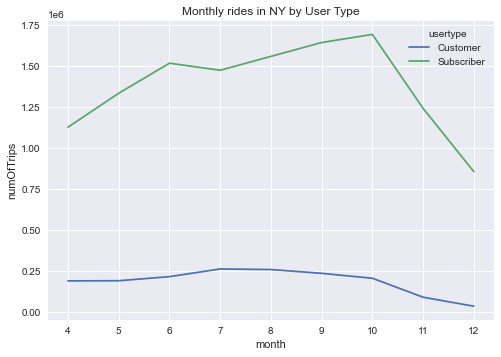

In [55]:
sns.lineplot(x='month',y='numOfTrips', hue='usertype',data=monthlyRides).set_title('Monthly rides in NY by User Type')

### Age Bike Trips

In [45]:
AgeRiders = bigQuery(
    """
    SELECT birth_year,
    avg(tripduration)/60 AS AvgTripDuration,
    count(*) AS trips
    FROM `bigquery-public-data.new_york_citibike.citibike_trips`
    WHERE starttime > date('2017-01-01') and 
    starttime < date('2018-01-01')
    GROUP BY birth_year
    ORDER BY trips DESC;
    """
)

In [46]:
AgeRiders=AgeRiders.dropna(axis=0).astype(int)
AgeRiders=AgeRiders[AgeRiders.birth_year >= 1946]
AgeRiders['age'] = 2021 - AgeRiders['birth_year']

In [47]:
AgeRiders.head()

,birth_year,AvgTripDuration,trips,age
1,1989,14,539754,32
2,1988,15,536772,33
3,1990,15,531733,31
4,1987,30,520262,34
5,1986,14,512588,35


People in their 30s obviously have somewhere to go and want to stay active! Let's visualize this.

Text(0.5, 1.0, 'Total Trips in 2017 by Age in NY')

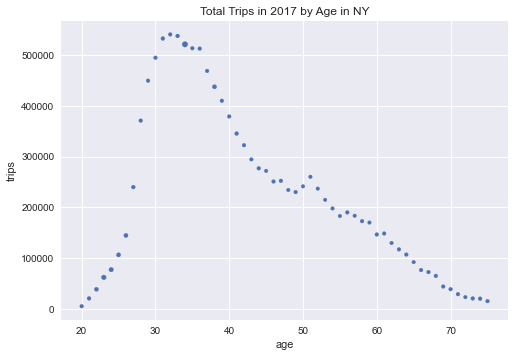

In [50]:
AgeRiders.plot(x='age',y='trips',s='AvgTripDuration',kind='scatter')
plt.title('Total Trips in 2017 by Age in NY')

### Time Bike Trips

In [17]:
bikeHour = bigQuery(
    """
    SELECT
    EXTRACT(hour from starttime) as starthour,
    count(*) AS numOfTrips
    FROM `bigquery-public-data.new_york_citibike.citibike_trips`
    WHERE starttime > date('2017-01-01') and starttime < date('2018-01-01')
    GROUP BY starthour
    ORDER BY starthour
    """
)

In [19]:
bikeHour.head()

,starthour,numOfTrips
0,0,125193
1,1,68826
2,2,38997
3,3,23703
4,4,23432


Text(0.5, 1.0, 'Number of Trips in 2017 by Hour')

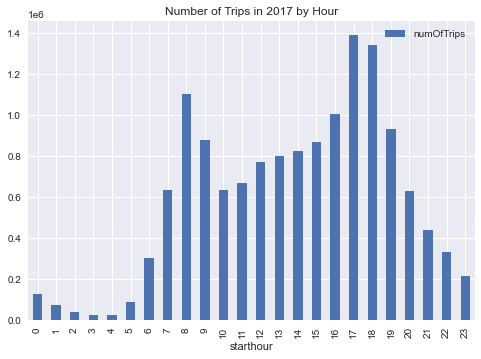

In [27]:
bikeHour.plot(x='starthour',y='numOfTrips',kind='bar').set_title('Number of Trips in 2017 by Hour')

## Survey Manipulation

In [17]:
import pandas as pd

In [18]:
NYSurvey = pd.read_csv('Citywide_Mobility_Survey_-_Main_Survey_2017.csv')

/Users/tiareina/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [19]:
#list(NYSurvey.columns)

In [20]:
#[i for i in NYSurvey.columns if 'BIKE' in i or "bike" in i]

In [21]:
relCols = [
 'UniqueID',
 'StartTime_EST',
 'FinishTime_EST',
 'qgender',
 'qzipcmb',
 'qbikeown',
#  'qbikemany',
#  'qBIKETYPE1',
#  'qBIKETYPE2',
#  'qBIKETYPE3',
#  'qBIKETYPE4',
#  'qBIKETYPE5',
#  'qBIKETYPE_other3',
#  'qBIKESTORE1',
#  'qBIKESTORE2',
#  'qBIKESTORE3',
#  'qBIKESTORE4',
#  'qBIKESTORE5',
#  'qBIKESTORE6',
#  'qBIKESTORE7',
#  'qBIKESTORE8',
#  'qBIKESTORE9',
#  'qBIKESTORE_other7',
 'qbikeride',
 'qbiketo',
 'qbikedays',
 'qcitibike',
 'qcitibikefreq',
 'qNOCITIBIKE1',
 'qNOCITIBIKE2',
 'qNOCITIBIKE3',
 'qNOCITIBIKE4',
 'qNOCITIBIKE5',
 'qNOCITIBIKE6',
 'qNOCITIBIKE7',
 'qNOCITIBIKE8',
 'qNOCITIBIKE9',
 'qNOCITIBIKE_other7'
]

In [22]:
nyBikeDF = NYSurvey[relCols]

In [23]:
surveyBikeAvgs = nyBikeDF.groupby('qzipcmb')[['qbikeown','qbikeride']].agg(np.average)
#surveyBikeAvgs = surveyBikeAvgs[surveyBikeAvgs['']]

<AxesSubplot:xlabel='qzipcmb', ylabel='qbikeown'>

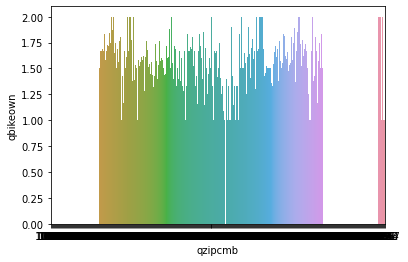

In [24]:
sns.barplot(y='qbikeown', x=surveyBikeAvgs.index, data=surveyBikeAvgs)

In [26]:
def spaceReplacer(data):
    if data == " ":
        return np. NaN
    else:
        return data

In [27]:
nyBikeDF['qcitibikefreq'] = nyBikeDF['qcitibikefreq'].apply(spaceReplacer).astype(float)

<ipython-input-27-a1d1909f563b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyBikeDF['qcitibikefreq'] = nyBikeDF['qcitibikefreq'].apply(spaceReplacer).astype(float)


In [54]:
nyBikeDF[nyBikeDF['qcitibike']==1.0]

,UniqueID,StartTime_EST,FinishTime_EST,qgender,qzipcmb,qbikeown,qbikemany,qBIKETYPE1,qBIKETYPE2,qBIKETYPE3,...,qNOCITIBIKE1,qNOCITIBIKE2,qNOCITIBIKE3,qNOCITIBIKE4,qNOCITIBIKE5,qNOCITIBIKE6,qNOCITIBIKE7,qNOCITIBIKE8,qNOCITIBIKE9,qNOCITIBIKE_other7
61,110000136.0,05/20/2017,,2.0,11230,1.0,4,1,0,0,...,,,,,,,,,,
65,110000141.0,05/20/2017,,1.0,11215,1.0,2,1,0,0,...,,,,,,,,,,
84,110000200.0,05/21/2017,,2.0,10025,1.0,3,1,0,0,...,,,,,,,,,,
89,110000214.0,05/21/2017,,2.0,10002,2.0,0,,,,...,,,,,,,,,,
166,110000475.0,05/24/2017,,2.0,10012,1.0,3,1,0,0,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3565,200013134.0,06/29/2017,6/29/2017,1.0,10461,2.0,,,,,...,,,,,,,,,,
3566,200013138.0,06/29/2017,6/29/2017,2.0,11373,1.0,4,1,0,0,...,,,,,,,,,,
3568,200013147.0,06/29/2017,6/29/2017,1.0,10467,1.0,1,0,1,0,...,,,,,,,,,,
3588,200013473.0,06/30/2017,6/30/2017,2.0,10453,2.0,,,,,...,,,,,,,,,,


## Connecting NY Lat, Long to the zips

In [30]:
nytrips = bigQuery(
    """
    SELECT  *
    FROM `bigquery-public-data.new_york_citibike.citibike_trips` 
    WHERE starttime > date('2017-01-01T00:00:00')
    LIMIT 10
    """
)

In [31]:
nytrips[['start_station_latitude','start_station_longitude']]

,start_station_latitude,start_station_longitude
0,40.784727,-73.969617
1,40.727064,-73.996621
2,40.695128,-73.995951
3,40.708531,-73.964090
4,40.690081,-73.947915
5,40.777057,-73.978985
6,40.763094,-73.978350
7,40.722174,-73.983688
8,40.661063,-73.979453
9,40.731437,-73.994903


In [38]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="NYBikeShare Mapping")

NYZipCodes = []

for i in nytrips[['start_station_latitude','start_station_longitude']].values:
    location = geolocator.reverse(i)
    NYZipCodes.append([i, location.address.split(',')[-2]])

In [48]:
# Some entries won't have a zip code the way they are entered into the database. I don't know how we'd want to handle that if we want to use this method
# Which would be extract the long, lat from BQ, and 
pd.DataFrame(NYZipCodes,nytrips).reset_index().drop('index',axis=1)

,0,1
0,"[40.78472675, -73.96961715]",10024
1,"[40.72706363348306, -73.99662137031554]",10003
2,"[40.69512845, -73.99595065]",11201
3,"[40.70853074, -73.96408963]",11249
4,"[40.6900815, -73.947915]",11216
5,"[40.7770575, -73.97898475]",10025
6,"[40.76309387270797, -73.9783501625061]",New York
7,"[40.72217444, -73.98368779]",10009
8,"[40.6610633719006, -73.97945255041122]",11215
9,"[40.73143724085228, -73.99490341544151]",10003


## Comparison